In [1]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.preprocessing import OneHotEncoder
import lightning.pytorch as L
from model import CVAE
from datetime import datetime
from os.path import join
import pytz
from anndata import AnnData

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!aws s3 cp s3://insitro-user/haoyang/gb/cells.npy .

download: s3://insitro-user/haoyang/gb/cells.npy to ./cells.npy     


In [4]:
cell_file = "cells.npy"
cells = np.load(cell_file, allow_pickle=True).ravel()[0]

expressions = cells["UMI"].toarray()  # sparse matrix of gene expressions
gene_names = cells["gene_ids"]  # gene names
cell_classes = cells["classes"]  # cell classes

In [5]:
expressions.max()

260.0

In [6]:
obs = pd.DataFrame()
obs["classes"] = cell_classes

var = pd.DataFrame(index=gene_names)

adata = AnnData(X=expressions, obs=obs, var=var)
adata

/home/ubuntu/miniconda3/envs/scvi/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 65943 × 16769
    obs: 'classes'

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)


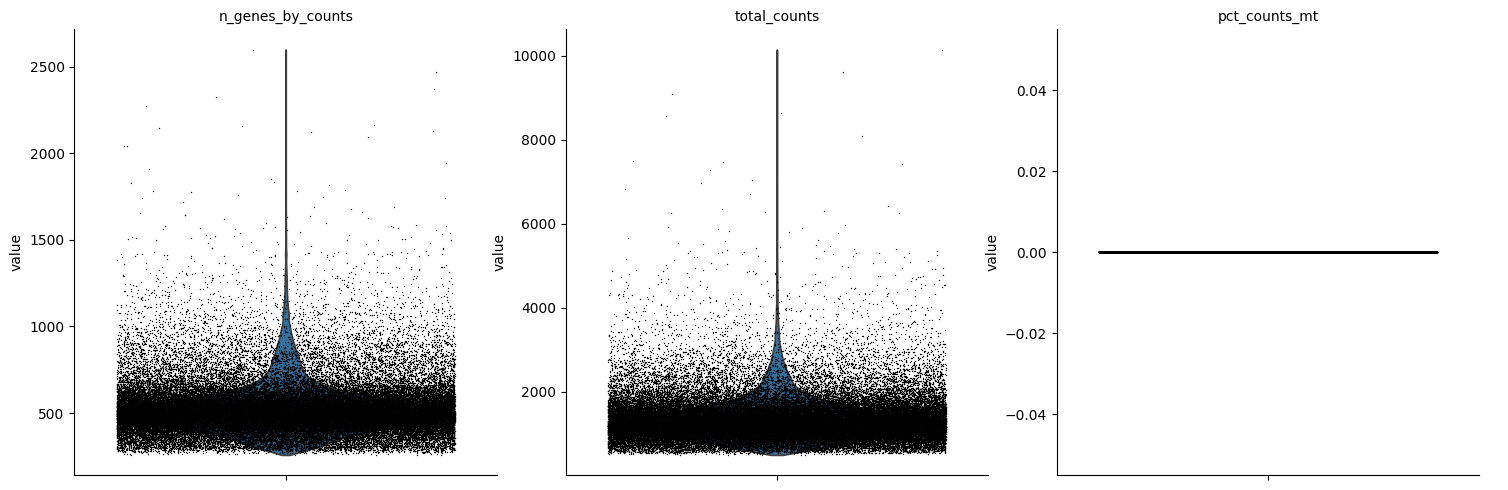

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

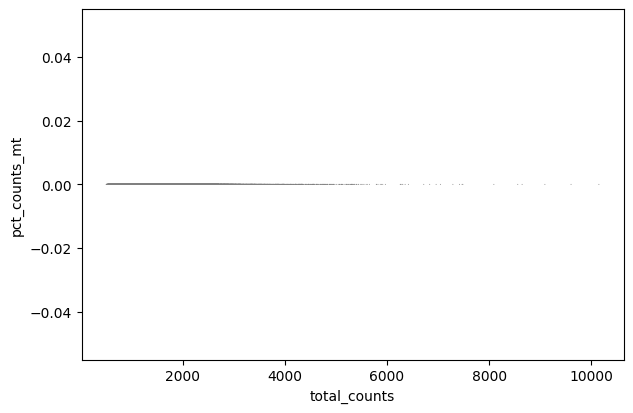

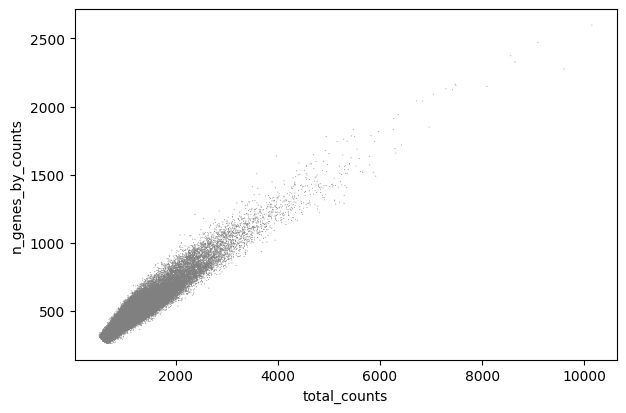

In [10]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
#adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [12]:
adata.raw = adata.copy()

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [14]:
sc.pp.log1p(adata)

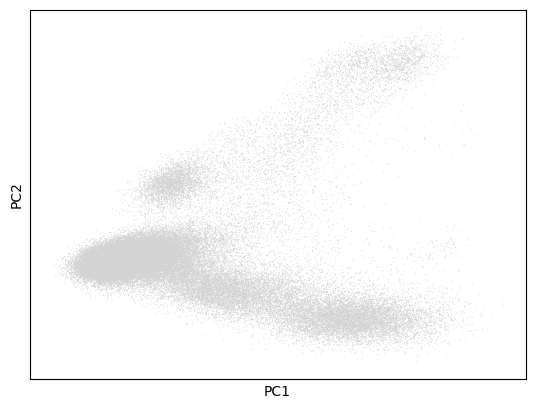

In [15]:
sc.tl.pca(adata)
sc.pl.pca(adata)

/home/ubuntu/miniconda3/envs/scvi/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


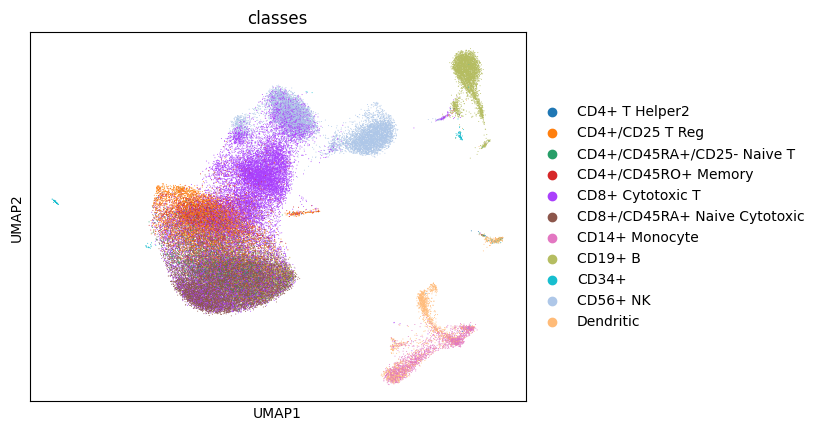

In [16]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="classes")

In [17]:
adata2output = adata.copy()
adata2output.X = adata2output.raw.X
adata2output.X.max()

260.0

In [18]:
adata2output.write_h5ad("post_qc.h5ad")